In [1]:
import pandas as pd
import time
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

In [20]:
google_df_import = pd.read_csv("../Data/cleaned.csv",encoding='cp1252')
# google_df = google_df.sample(n=1000, random_state=1) #uncomment to run on sample

In [21]:
google_df = google_df_import.copy()

### preperation

## preliminary analysis

based on: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ 

### statistics on variables

Counts and distribution of 3 main variables of interest.

In [ ]:
regression_df = google_df[['free_app']]

In [4]:
google_df.columns

Index(['my_app_id', 'rating_app', 'nb_rating', 'num_downloads', 'price_gplay',
       'has_ads', 'in_app', 'num_downloads_cat', 'year_published', 'version',
       'free_app', 'freeApp_x_hasAds', 'freeApp_x_inApp',
       'freeApp_x_hasAds_inApp', 'Action', 'Action & Adventure', 'Adventure',
       'Arcade', 'Art & Design', 'Auto & Vehicles', 'Beauty', 'Board',
       'Books & Reference', 'Brain Games', 'Business', 'Card', 'Casino',
       'Casual', 'Comics', 'Communication', 'Creativity', 'Dating',
       'Education', 'Educational', 'Entertainment', 'Events', 'Finance',
       'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Maps & Navigation', 'Medical', 'Music', 'Music & Audio',
       'Music & Video', 'News & Magazines', 'Parenting', 'Personalization',
       'Photography', 'Pretend Play', 'Productivity', 'Puzzle', 'Racing',
       'Role Playing', 'Shopping', 'Simulation', 'Social', 'Sports',
       'Strategy', 'Tools', 'Travel & Local', 

In [4]:
print('Total number of apps = ' + str(len(google_df)))
print(str(len(google_df[google_df.free_app == 1])) + ' free apps, ' + str(len(google_df[google_df.free_app == 0])) + ' paid apps.' + 
      '(' + str(round(len(google_df[google_df.free_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.free_app == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.has_ads == 1])) + ' apps with advertisements, ' + str(len(google_df[google_df.has_ads == 0])) + ' apps without ads.' + 
      '(' + str(round(len(google_df[google_df.has_ads == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.has_ads == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.in_app == 1])) + ' apps with in-app purchases, ' + str(len(google_df[google_df.in_app == 0])) + ' apps without in-app purchases.' + 
     '(' + str(round(len(google_df[google_df.in_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.in_app == 0]) / len(google_df) * 100, 1)) + '%)')

Total number of apps = 775694
714269 free apps, 61425 paid apps.(92.1%, 7.9%)
403456 apps with advertisements, 372238 apps without ads.(52.0%, 48.0%)
90917 apps with in-app purchases, 684777 apps without in-app purchases.(11.7%, 88.3%)


In [11]:
google_df.num_downloads_cat.value_counts()

1000 - 9999        238190
10000 - 99999      207670
100 - 999          150119
100000 - 999999    101051
0 - 99              45590
1000000 +           33047
Name: num_downloads_cat, dtype: int64

In [57]:
google_df[google_df.rating_app == 5].nb_rating.value_counts()

1.0        25662
2.0        15210
3.0         9979
4.0         6743
5.0         4652
           ...  
436.0          1
256.0          1
533.0          1
15337.0        1
207.0          1
Name: nb_rating, Length: 304, dtype: int64

In [4]:
len(google_df[google_df.rating_app == 5])

81109

In [14]:
google_df[google_df.rating_app == 5].nb_rating.value_counts()

1.0        25662
2.0        15210
3.0         9979
4.0         6743
5.0         4652
           ...  
436.0          1
256.0          1
533.0          1
15337.0        1
207.0          1
Name: nb_rating, Length: 304, dtype: int64

In [ ]:
def multiple_displot(data, features):
    sns.pairplot(data[features])
    
features = ['nb_rating', 'num_downloads', 'year_published', 'version']
multiple_displot(google_df, features)

### Correlations between all variables (correlation) (Jari)

In [103]:
def multicollinearity_assumption(google_data):

    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    corr_matrix = google_data.corr()
    print(corr_matrix)
    sns.heatmap(corr_matrix, annot=True)
    plt.title('Correlation of Variables')
    plt.show()

                        rating_app  nb_rating  num_downloads   has_ads  \
rating_app                1.000000   0.009151       0.004600  0.043729   
nb_rating                 0.009151   1.000000       0.472574  0.009790   
num_downloads             0.004600   0.472574       1.000000  0.006476   
has_ads                   0.043729   0.009790       0.006476  1.000000   
in_app                   -0.000320   0.036211       0.017481  0.145559   
free_app                  0.002638   0.006682       0.006672  0.281879   
freeApp_x_hasAds          0.044506   0.009983       0.006719  0.987912   
freeApp_x_inApp          -0.001348   0.036782       0.017927  0.154778   
freeApp_x_hasAds_inApp    0.017181   0.034087       0.017733  0.288950   

                          in_app  free_app  freeApp_x_hasAds  freeApp_x_inApp  \
rating_app             -0.000320  0.002638          0.044506        -0.001348   
nb_rating               0.036211  0.006682          0.009983         0.036782   
num_downloads   

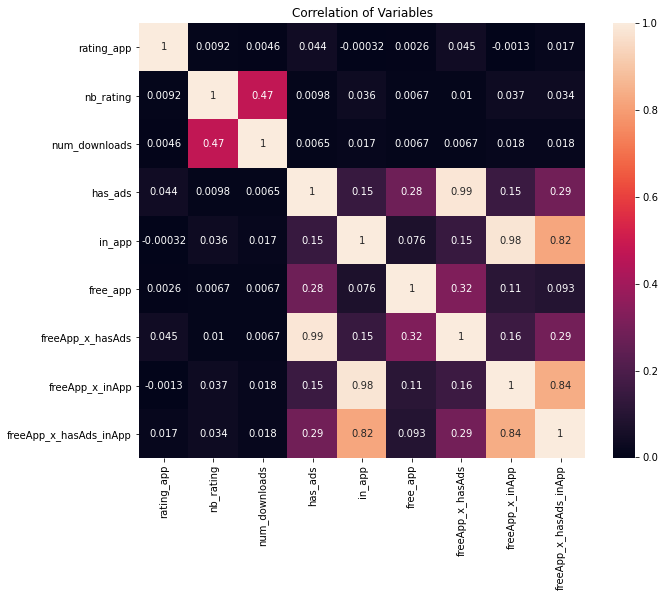

In [104]:
multicollinearity_assumption(google_df)

### autocorelation assumption (jari)

In [110]:
def autocorrelation_assumption(google_df):

    from statsmodels.stats.stattools import durbin_watson
   
    # Calculating residuals for the Durbin Watson-tests
    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(result.resid)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [111]:
autocorrelation_assumption(google_df)


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.627439208746623
Little to no autocorrelation 

Assumption satisfied


### Normal distribution of all variables (Floris)

Shapiro-Swilk test:
Statistics=0.898, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test


C:\Users\s159907\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=202911.076, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:
Statistic: 16974.077
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------


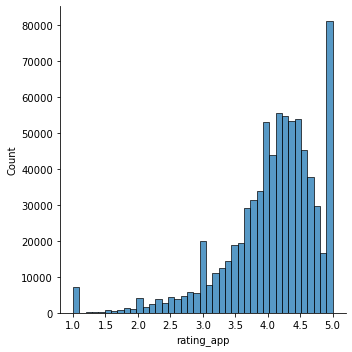

In [46]:
def check_normal_dist(data, target):
    #visualize the distribution
    sns.displot(data, x=str(target), bins = len(data[target].value_counts()))
    #visualize the same distribution, also showing the division in free and paid apps
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="free_app", multiple="stack")
    
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="in_app", multiple="stack")
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="has_ads", multiple="stack")

    # Perform and evaluate three normality tests: Shapiro-Swilk, D’Agostino’s K^2, and Anderson-Darling Test. 
    print('Shapiro-Swilk test:')
    stat, p = stats.shapiro(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
        
    print('D’Agostino’s K^2 Test')
    stat, p = stats.normaltest(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
    
    print('Anderson-Darling Test:')
    result = stats.anderson(data[target])
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    print('-------------------------------------------')
    
check_normal_dist(google_df, 'rating_app')

In [40]:
google_df.loc[google_df.nb_rating <= 0]

Empty DataFrame
Columns: [my_app_id, rating_app, nb_rating, num_downloads, price_gplay, has_ads, in_app, num_downloads_cat, year_published, version, free_app, freeApp_x_hasAds, freeApp_x_inApp, freeApp_x_hasAds_inApp, Action, Action & Adventure, Adventure, Arcade, Art & Design, Auto & Vehicles, Beauty, Board, Books & Reference, Brain Games, Business, Card, Casino, Casual, Comics, Communication, Creativity, Dating, Education, Educational, Entertainment, Events, Finance, Food & Drink, Health & Fitness, House & Home, Libraries & Demo, Lifestyle, Maps & Navigation, Medical, Music, Music & Audio, Music & Video, News & Magazines, Parenting, Personalization, Photography, Pretend Play, Productivity, Puzzle, Racing, Role Playing, Shopping, Simulation, Social, Sports, Strategy, Tools, Travel & Local, Trivia, Video Players & Editors, Weather, Word]
Index: []

[0 rows x 67 columns]

Shapiro-Swilk test:
Statistics=0.985, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=12952.872, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:


C:\Users\s159907\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic: 1695.749
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------
Shapiro-Swilk test:
Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test


C:\Users\s159907\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=11948.100, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:
Statistic: 1598.026
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------


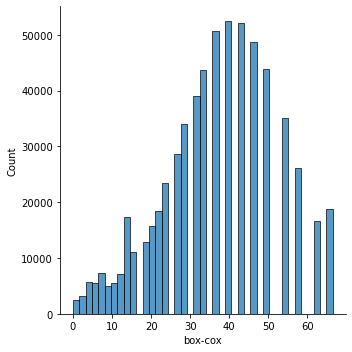

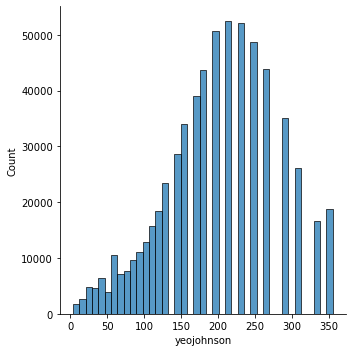

In [53]:
def normalize_data(data, feature):
    transform = google_df[['rating_app', 'nb_rating']].copy()
    transform = transform.loc[transform.nb_rating > 5]

    transform['box-cox'],_ = stats.boxcox(transform['rating_app'])
    transform['yeojohnson'],_ = stats.yeojohnson(transform['rating_app'])
    check_normal_dist(transform, 'box-cox')
    check_normal_dist(transform, 'yeojohnson')


#     return transform

normalize_data(google_df, 'rating_app')

In [55]:
len(google_df.loc[google_df.nb_rating > 10])

556441

Shapiro-Swilk test:
Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=128591.307, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:


C:\Users\s159907\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic: 12053.448
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------


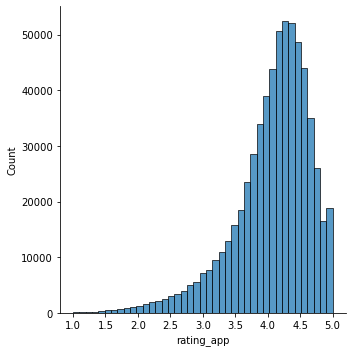

In [56]:
check_normal_dist(google_df.loc[google_df.nb_rating > 5], 'rating_app')

### check linearity of variables (Jari)

In [18]:
def linear_assumption(google_df):


    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()
    

    google_df_new = pd.DataFrame(columns=['y_pred', 'y_true'])
    google_df_new['y_pred'] = result.predict()
    google_df_new['y_true'] = google_df.rating_app
    print(google_df_new)
    google_df_new = google_df_new.dropna()

    # Plotting the actual vs predicted values
    sns.lmplot(x = 'y_pred', y = 'y_true',  data = google_df_new)
    plt.title('Actual vs. Predicted')
    plt.ylim(0, 5)
    plt.xlim(0, 5)
    plt.show()

In [17]:
linear_assumption(google_df)

[[4.5]
 [4.5]
 [4.4]
 ...
 [4.9]
 [nan]
 [3.9]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### homoscedasticity assumptions (Floris)

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def check_homoscedasticity(target, features, model):
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, target)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

features = []
used_model = 
check_homoscedasticity(google_df['rating_app'], features, used_model)

## Analysis

### Run first OLS for interpretation

In [17]:
google_df = google_df.rename(columns={'PEGI 12': 'PEGI_12'})

In [22]:
[value for value in google_df.columns]

['my_app_id',
 'rating_app',
 'nb_rating',
 'num_downloads',
 'price_gplay',
 'has_ads',
 'in_app',
 'num_downloads_cat',
 'more_from_developer',
 'year_published',
 'age',
 'PEGI_12',
 'PEGI_16',
 'PEGI_18',
 'PEGI_3',
 'PEGI_7',
 'Parenta',
 'Unrated',
 'nan_content',
 'nb_apps_developer',
 'version',
 'version_1.0',
 'version_1.1',
 'version_1.5',
 'version_1.6',
 'version_2.0',
 'version_2.1',
 'version_2.2',
 'version_2.3',
 'version_3.0',
 'version_3.1',
 'version_3.2',
 'version_4.0',
 'version_4.1',
 'version_4.2',
 'version_4.3',
 'version_4.4',
 'version_5.0',
 'version_5.1',
 'version_6.0',
 'version_7.0',
 'version_7.1',
 'version_8.0',
 'version_Var',
 'version_nan_os',
 'free_app',
 'freeApp_x_hasAds',
 'freeApp_x_inApp',
 'freeApp_x_hasAds_inApp',
 'Action',
 'Action & Adventure',
 'Adventure',
 'Arcade',
 'Art & Design',
 'Auto & Vehicles',
 'Beauty',
 'Board',
 'Books & Reference',
 'Brain Games',
 'Business',
 'Card',
 'Casino',
 'Casual',
 'Comics',
 'Communication',

In [26]:
result = sm.ols(formula=
                "rating_app ~ free_app + nb_rating + year_published + age + PEGI_12 + PEGI_16 + PEGI_18 + PEGI_3 + PEGI_7 + Parenta + Unrated + nb_apps_developer", 
                data=google_df).fit()

''' + version_1.0 + version_1.1 + version_1.5 + version_1.6 + version_2.0 + version_2.1 + version_2.2 + version_2.3 + 
version_3.0 + version_3.1 + version_3.2 + version_4.0 + version_4.1 + version_4.2 + version_4.3 + version_4.4 + version_5.0 + version_5.1 + version_6.0 + version_7.0 + version_7.1 + version_8.0 + Var + nan_os'''

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     155.1
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:56:43   Log-Likelihood:            -8.5588e+05
No. Observations:              775693   AIC:                         1.712e+06
Df Residuals:                  775682   BIC:                         1.712e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.627e-06   2.09e-0

In [27]:
result = sm.ols(formula=
                "rating_app ~ has_ads + nb_rating + year_published + age + PEGI_12 + PEGI_16 + PEGI_18 + PEGI_3 + PEGI_7 + Parenta + Unrated + nb_apps_developer", 
                data=google_df).fit()

''' + version_1.0 + version_1.1 + version_1.5 + version_1.6 + version_2.0 + version_2.1 + version_2.2 + version_2.3 + 
version_3.0 + version_3.1 + version_3.2 + version_4.0 + version_4.1 + version_4.2 + version_4.3 + version_4.4 + version_5.0 + version_5.1 + version_6.0 + version_7.0 + version_7.1 + version_8.0 + Var + nan_os'''

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     315.9
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:05:59   Log-Likelihood:            -8.5508e+05
No. Observations:              775693   AIC:                         1.710e+06
Df Residuals:                  775682   BIC:                         1.710e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.493e-06   2.07e-0

In [16]:
google_df['PEGI 12']

0         0
1         0
2         0
3         0
4         0
         ..
775689    0
775690    1
775691    1
775692    0
775693    0
Name: PEGI 12, Length: 775694, dtype: int64